## Análisis del *MNE BNCI Horizon 2020 Dataset 008-2014*
  
[- Análisis de Rodrigo.](https://github.com/faturita/python-nerv/blob/master/MNE%20BNCI%20Horizon%202020%20Dataset%20008-2014.ipynb)  
    
[- *MNE BNCI Horizon Dataset: 8. P300 speller with ALS patients (008-2014).*](http://bnci-horizon-2020.eu/database/data-sets)  
  
*- Éste dataset, el bnci: A01.mat ... A08.mat, son registros completos CON potenciales evocados P300 de pacientes con Esclerosis lateral amiotrófica (ELA).*  
  
OJO: En los otros datasets, el órden cambia.  
Por ejemplo, en un p300-subject-XX.mat, es: Targets / No targets mat['data'][0][0][1] y Stims/ No Stims mat['data'][0][0][2].  
  
Dentro del data.flash, en el caso del dataset de archivos P300SXX.mat, el hit/nohit está en:  
Sample point where each flashing starts (sample point id, duration, stimulation, hit/nohit).  
  
t_type: Targets / No targets  | Hits and nohits.  
  
Sobre una consulta:  
Previo a todo esto sólo se venía usando t_flash[:,0] y el t_flash[:,3], es decir, "sample point id" y "hit/nohit", ahora ya tocamos todas las variables: sample point id, duration, stimulation, hit/nohit.
  
Esas variables son las marcas que te indica si cada estimulación representa un caso de hit, no-hit, y por otro lado te marcan la fila o la columna de la estimulación.  No vas a ver nada en los gráficos, son variables armadas en base a las otras.  


In [1]:
import mne
mne.set_log_level('WARNING')
#https://martinos.org/mne/stable/auto_tutorials/plot_creating_data_structures.html#tut-creating-data-structures
import scipy.io
import numpy as np


color = ['green', 'blue','red','cyan', 'magenta', 'yellow','k','w']     # Paleta de colores para diferenciar las ondas
import a_funciones as a_fun                                             # Funciones Alex
xlabel = 'Muestra'                                                      # Abscisas
ylabel = 'Amplitud (uV)'                                                # Ordenadas

globalacc = []
globalavgacc = []
globalperformance = []

subject=1

# ============================================================
# Usé el EEG del paciente mas jóven: https://lampz.tugraz.at/~bci/database/008-2014/description.pdf
filename = './dataset/bnci/A'+'{:02d}'.format(subject)
mat = scipy.io.loadmat(filename)
# mat = scipy.io.loadmat('./dataset/bnci/A06.mat')
# filename = '/Users/rramele/GoogleDrive/BCI.Dataset/008-2014/A'+'{:02d}'.format(subject)
# mat = scipy.io.loadmat(filename)
# ============================================================
# - Para conocer el dataset
# ============================================================
# mat = scipy.io.loadmat('/Users/rramele/work/GuessMe/signals/p300-subject-01.mat')
# General structure -> mat['data'][0][0][0]
# Labels -> mat['data'][0][0][0][0][0]
# Data points  -> mat['data'][0][0][1]
# Targets / No tagets  -> mat['data'][0][0][2]
# Stimulations  -> mat['data'][0][0][3]
# Trials -> mat['data'][0][0][4]
# ============================================================
# - Cálculo de densidad espectral
# ============================================================
# Data point zero for the eight channels.  Should be in V.
signal = mat['data'][0][0][1] * pow(10,6)
print ('Signal shape (%2d, %2d)' % signal.shape)
ch_names=[ 'Fz'  ,  'Cz',    'Pz' ,   'Oz'  ,  'P3'  ,  'P4'   , 'PO7'   , 'PO8']
ch_types= ['eeg'] * signal.shape[1]
info = mne.create_info(ch_names, 256, ch_types=ch_types)
eeg_mne = mne.io.array.RawArray(signal.T, info)
# eeg_mne.plot_psd()
# ============================================================
# - Visualización del filtro de notch de 50 Hz con el que viene directamente este dataset:
# (Al aplicar el filtro de bandpass de 1-20 se eliminan los componentes de 20 Hz para arriba)
# ============================================================
# print ('Bandpass 1-20 Hz signal')
# eeg_mne.filter(1,20)
# eeg_mne.plot_psd()
# ============================================================
# - Clasificación Single-Trial
# Primero es necesario construir la estructura de datos de Epochs para después poder clasificar.
# La estructura contiene primero el canal con las estimulaciones, 
# los números del 1-12 que corresponden con los flashes correspondientes a las filas y las columnas.
# Luego en un segundo canal contiene los marcadores de hit/nohit, 
# identificando cuál de las columnas o filas debería tener un disparo de P300.
# ============================================================
ch_names_events = ch_names + ['t_stim']+ ['t_type']
ch_types_events = ch_types + ['misc'] + ['misc']

t_stim = mat['data'][0][0][3]                                           # Estimulaciones del speller (data.y_stim: Stimulation number: 1-6 rows, 7-12 cols)
t_type = mat['data'][0][0][2]                                           # Targets / No targets  | Hits and nohits

signal_events = np.concatenate([signal, t_stim, t_type],1)              # Concatena horizontal.
df_signal_events = a_fun.to_df(signal_events)

info_events = mne.create_info(ch_names_events,256, ch_types_events)
eeg_events = mne.io.RawArray(signal_events.T, info_events)
#eeg_events.plot(n_channels=10, scalings='auto')
# ============================================================

Signal shape (347704,  8)


##### Luego armo acá la descripción detallada de lo que pasa abajo.
##### El event_times se ejecuta tres veces, una con t_stim y dos con t_type.
##### Con t_type le agrega tmin = 0, por que? tmax = 0.8
##### Hacerle un print para que se entienda print ('Nohits:')

Found 4200 events, first five:
[[1800    0    1]
 [1864    0    2]
 [1928    0    6]
 [1992    0    4]
 [2056    0    3]]
Nohits:
Epochs x channels x time
(3500, 8, 206)


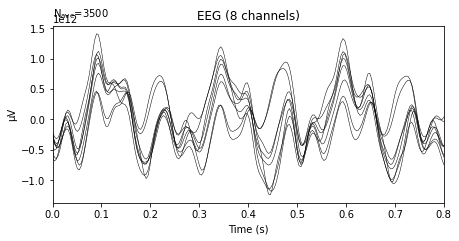

Hits:
Epochs x channels x time
(700, 8, 206)


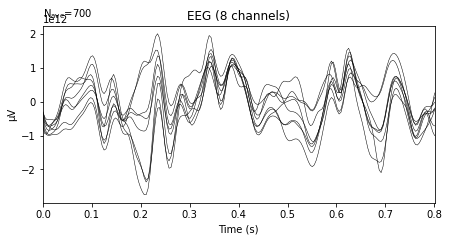

Los 8 canales de EEG con los eventos en azul donde se disparan cada una de las estimulaciones.


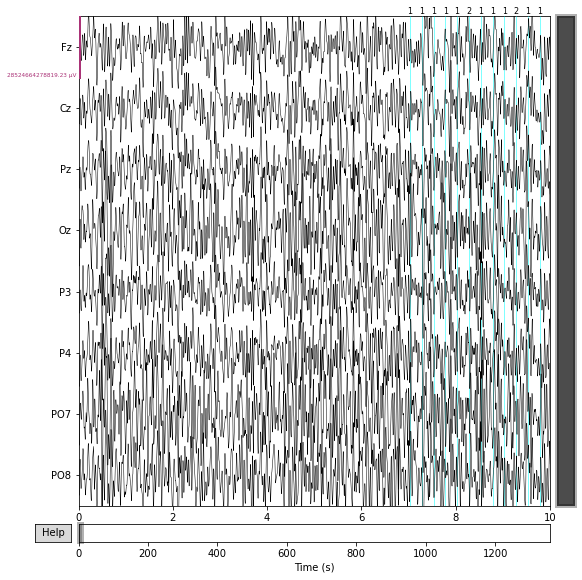

,0,1,2,sample
0,1800,0,1,0
1,1864,0,2,1
2,1928,0,6,2
3,1992,0,4,3
4,2056,0,3,4


In [3]:
# ============================================================
# 1. "find_events" con t_stim
# ============================================================
event_times = mne.find_events(eeg_events, stim_channel='t_stim')
# df_event_times = a_fun.to_df(event_times)
# df_event_times.head()
print('Found %s events, first five:' % len(event_times))
print(event_times[:5])

# Plot the events to get an idea of the paradigm
# Specify colors and an event_id dictionary for the legend.
color = {1: 'green', 2: 'yellow', 3: 'red', 4: 'c', 5: 'black', 6: 'blue',7: 'green', 8: 'yellow', 9: 'red', 10: 'c', 11: 'black', 12: 'blue'}

# El primero paso para intentar la clasificación es analizar el GRAND AVERAGE de las señales.  
# Esto es tomar todos los segmentos sincronizados con las estimulaciones que corresponden con un HIT/NOHIT 
# y calcular la señal promedio (por cómo está armado el dataset, serán 700 vs 3500 segmentos).

# Los epochs se generan a partir de la información de los momentos donde se producen las estimulaciones.  
# Cada segmento se extrae de la señal de EEG desde los 0 a los 0.8 s.  
# Abajo, en el primer gráfico, se visualiza el grand average de los 3500 segmentos correspondientes a los nohits.  
# Se visualiza los picos de las señal de 4 Hz correspondiente al ISI de 0.125 ms que tiene asginado este dataset 
# (falta un pico porque es hasta los 800 ms).  En el segundo gráfico, se visualiza, aún mezclado entre ruído, el P300.
# ============================================================

# ============================================================
# 2. "find_events" con t_type y extrae la "época"
# ============================================================
event_times = mne.find_events(eeg_events, stim_channel='t_type')

tmin = 0
tmax = 0.8

epochs = mne.Epochs(eeg_mne, event_times, {'first':1}, tmin, tmax, baseline=None)

print ('Nohits:')
print ('Epochs x channels x time')
print (epochs.get_data().shape)

evoked = epochs.average()
evoked.plot()

# ============================================================
# 2. "find_events" con t_type extrae la "época"
# ============================================================
event_times = mne.find_events(eeg_events, stim_channel='t_type')

tmin = 0
tmax = 0.8

epochs = mne.Epochs(eeg_mne, event_times, { 'second':2 }, tmin, tmax, baseline=None)

print ('Hits:')
print ('Epochs x channels x time')
print (epochs.get_data().shape)

evoked = epochs.average()
evoked.plot()

print ('Los 8 canales de EEG con los eventos en azul donde se disparan cada una de las estimulaciones.')
eeg_mne.plot(scalings='auto',n_channels=8,events=event_times)

In [ ]:
# montage = mne.channels.read_montage('standard_1020')
# eeg_mne.set_montage(montage)
# eeg_mne.plot_sensors()

from PIL import Image
sensors = Image.open('./a_images/Posicion_electrodos.jpg')
print ('Este es el montaje utilizado para la captura de este dataset.')
sensors.show()

In [ ]:
print ('Por ahora, para facilitar la programación posterior, no vamos a estar eliminando artefactos')
print ('ni tampoco aplicando un ajuste de baseline (detrending).')
event_id = { 'first':1, 'second':2 }
#baseline = (0.0, 0.2)
#reject = {'eeg': 70 * pow(10,6)}
reject = None
epochs = mne.Epochs(eeg_mne, event_times, event_id, tmin, tmax, proj=False,
                baseline=None, reject=reject, preload=True,
                verbose=True)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

# Create classification pipeline
clf = make_pipeline(mne.preprocessing.Xdawn(n_components=3),
                    mne.decoding.Vectorizer(),
                    MinMaxScaler(),
                    LogisticRegression(penalty='l1'))


Para clasificar los epochs single-trial vamos a usar XDAWN con tres componentes.  Las señales se vectorizan con el método de Kasinsky, concatenandola sample a sample, canal a canal.  Los valores se estandarizan con MinMax Scaler de SKLearn y finalmente se aplica un clasificador por regresión logística (LDA).

In [ ]:
labels = epochs.events[:, -1]
lbls = labels

# Cross validator
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

epochs.resample(20, npad="auto")

Los epochs se RESAMPLEAN a 20 Hz (los segmentos que originalmente tenían 206 muestras pasan a tener 16)

In [ ]:
epochs.get_data().shape

In [ ]:
# Do cross-validation
preds = np.empty(len(labels))
for train, test in cv.split(epochs,labels):
    cf=clf.fit(epochs[train], labels[train])
    preds[test] = clf.predict(epochs[test])

prds = preds

# Classification report
target_names = ['nohit', 'hit']

report = classification_report(labels, preds, target_names=target_names)
print(report)

cm = confusion_matrix(labels, preds)
print (cm)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
acc=(cm[0,0]+cm[1,1])*1.0/(np.sum(cm))

print ('Acc Crudo:'+str(acc))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot confusion matrix
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
mne.viz.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:
np.where( labels == 3 )

y_score = cf.decision_function(epochs)
fpr, tpr, _ = roc_curve(labels, y_score,pos_label=2)
roc_auc = auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

De la curva de ROC se ve que la clasificación no es al azar.  Aún así, dista de ser realmente funcional.

# Clasificación Binaria por trial

Para cada uno de los 35 trials (las 35 letras de las 7 palabras de 5 letras) se calcula el promediado de los hits vs los hits para cada uno y luego se trata de identificar si un promedio de señales es hit o no.

In [ ]:
print ('Averaged classification per trials (20 reps vs 100 reps)')

repetitions=120

for trial in range(0,35):
    epochstrial = epochs[0+repetitions*trial:repetitions*trial+repetitions]

    epochstrial1 = epochstrial['first']
    epochstrial2 = epochstrial['second']

    print ('Epochs x channels x time')
    print (epochstrial.get_data().shape)

    if (trial==0):
        evoked_nohit = epochstrial1.average()
        epochs_data = np.array([evoked_nohit.data])
    else:
        epochs_data = np.concatenate((epochs_data, [epochstrial1.average().data]), axis=0)
    epochs_data = np.concatenate((epochs_data, [epochstrial2.average().data]), axis=0)


Se crea una estructura de epochs donde se componen los 70 segmentos, donde 35 corresponden a hits y 35 a no hits.

In [ ]:
labels = np.array([1,2]*35)

#labels = np.random.randint(1,3,70)

events = np.array([
[1, 0, 1],
[2, 0, 2],
[3, 0, 1],
[4, 0, 2],
[5, 0, 1],
[6, 0, 2],
[7, 0, 1],
[8, 0, 2],
[9, 0, 1],
[10, 0, 2],
[11, 0, 1],
[12, 0, 2],
[13, 0, 1],
[14, 0, 2],
[15, 0, 1],
[16, 0, 2],
[17, 0, 1],
[18, 0, 2],
[19, 0, 1],
[20, 0, 2],
[21, 0, 1],
[22, 0, 2],
[23, 0, 1],
[24, 0, 2],
[25, 0, 1],
[26, 0, 2],
[27, 0, 1],
[28, 0, 2],
[29, 0, 1],
[30, 0, 2],
[31, 0, 1],
[32, 0, 2],
[33, 0, 1],
[34, 0, 2],
[35, 0, 1],
[36, 0, 2],
[37, 0, 1],
[38, 0, 2],
[39, 0, 1],
[40, 0, 2],
[41, 0, 1],
[42, 0, 2],
[43, 0, 1],
[44, 0, 2],
[45, 0, 1],
[46, 0, 2],
[47, 0, 1],
[48, 0, 2],
[49, 0, 1],
[50, 0, 2],
[51, 0, 1],
[52, 0, 2],
[53, 0, 1],
[54, 0, 2],
[55, 0, 1],
[56, 0, 2],
[57, 0, 1],
[58, 0, 2],
[59, 0, 1],
[60, 0, 2],
[61, 0, 1],
[62, 0, 2],
[63, 0, 1],
[64, 0, 2],
[65, 0, 1],
[66, 0, 2],
[67, 0, 1],
[68, 0, 2],
[69, 0, 1],
[70, 0, 2]
])

events[:,2] = labels

# Cross validator
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

custom_epochs = mne.EpochsArray(epochs_data, info, events, tmin, event_id)


In [ ]:
# Do cross-validation
preds = np.empty(len(labels))
for train, test in cv.split(custom_epochs,labels):
    cf=clf.fit(custom_epochs[train], labels[train])
    preds[test] = clf.predict(custom_epochs[test])

In [ ]:
target_names = ['nohit', 'hit']

report = classification_report(labels, preds, target_names=target_names)
print(report)

cm = confusion_matrix(labels, preds)
print (cm)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
acc=(cm[0,0]+cm[1,1])*1.0/(np.sum(cm))

print('Accuracy per trial:'+str(acc))

Noventa por ciento de acierto, con validación cruzada (1-out).  El detalle es que acá los promedios de señales se arman 10 contra 2.

# Performance, la posta

El valor de verdad lo tiene la capacidad del clasificador de acertar las letras de la matriz de P300.  Para eso, se utilizan los primeros 15 trials (las primeras tres palabras) para entrenar el clasificador y luego se usan los restantes 20 trials (las restantes cuatro palabras) donde se intenta decodificar la palabra seleccionada en base a la presencia del P300.

Primero hay que separar a los epochs con la información de las estimulaciones, para luego poder promediar cada tipo de estimulo x separado dentro de cada trial.

In [ ]:
print ('Averaged classification per row/column')

event_times = mne.find_events(eeg_events, stim_channel='t_stim')
event_id = {'Row1':1,'Row2':2,'Row3':3,'Row4':4,'Row5':5,'Row6':6,'Col1':7,'Col2':8,'Col3':9,'Col4':10,'Col5':11,'Col6':12}

epochs = mne.Epochs(eeg_mne, event_times, event_id, tmin, tmax, proj=False,
                baseline=None, reject=reject, preload=True,
                verbose=True)

repetitions=120

stims = event_times[:,-1]

La segunda parte es identificar la fila y la columna que se debería seleccionar en cada caso, en base a los rótulos de cada segmento.

In [ ]:
hlbls = []
hpreds = []
for trial in range(0,35):
    r = 0
    c = 0
    for i in range(0,6):
        if (lbls[0+120*trial+i]==2):
            r = stims[0+120*trial+i]
    for i in range(6,12):
        if (lbls[0+120*trial+i]==2):
            c = stims[0+120*trial+i]

    hlbls.append( (r,c) )

Luego se construyen los 420 labels (180 de entrenamiento + 240 de testing) asignados las estimulaciones.

In [ ]:
classlabels = []
for trial in range(0,35):
    for i in range(0,6):
        if (hlbls[trial][0]==(i+1)):
            classlabels.append(2)
        else:
            classlabels.append(1)
    for i in range(6,12):
        if (hlbls[trial][1]==(i+1)):
            classlabels.append(2)
        else:
            classlabels.append(1)

classlabels = np.array(classlabels)

Finalmente se promedia estímulo por estímulo

In [ ]:
for trial in range(0,35):
    epochstrial = epochs[0+repetitions*trial:repetitions*trial+repetitions]

    epochr1 = epochstrial['Row1']
    epochr2 = epochstrial['Row2']
    epochr3 = epochstrial['Row3']
    epochr4 = epochstrial['Row4']
    epochr5 = epochstrial['Row5']
    epochr6 = epochstrial['Row6']

    epochc1 = epochstrial['Col1']
    epochc2 = epochstrial['Col2']
    epochc3 = epochstrial['Col3']
    epochc4 = epochstrial['Col4']
    epochc5 = epochstrial['Col5']
    epochc6 = epochstrial['Col6']

    evoked = epochr1.average()
    if (trial==0):
        epochs_data = np.array([evoked.data])
    else:
        epochs_data = np.concatenate((epochs_data, [evoked.data]), axis=0)

    epochs_data = np.concatenate((epochs_data, [epochr2.average().data]), axis=0)
    epochs_data = np.concatenate((epochs_data, [epochr3.average().data]), axis=0)
    epochs_data = np.concatenate((epochs_data, [epochr4.average().data]), axis=0)
    epochs_data = np.concatenate((epochs_data, [epochr5.average().data]), axis=0)
    epochs_data = np.concatenate((epochs_data, [epochr6.average().data]), axis=0)

    epochs_data = np.concatenate((epochs_data, [epochc1.average().data]), axis=0)
    epochs_data = np.concatenate((epochs_data, [epochc2.average().data]), axis=0)
    epochs_data = np.concatenate((epochs_data, [epochc3.average().data]), axis=0)
    epochs_data = np.concatenate((epochs_data, [epochc4.average().data]), axis=0)
    epochs_data = np.concatenate((epochs_data, [epochc5.average().data]), axis=0)
    epochs_data = np.concatenate((epochs_data, [epochc6.average().data]), axis=0)


events=np.array([np.arange(420),np.zeros(420), classlabels])
events = events.T
events = events.astype(int)

event_id = { 'first':1, 'second':2 }
custom_epochs = mne.EpochsArray(epochs_data, info, events, tmin, event_id)


In [ ]:
print (custom_epochs)

Finalmente se hace la clasficación

In [ ]:
print('Performance Classification of Averaged Epochs')
test = range(180,420)
classpreds = np.empty(len(classlabels))
cf = clf.fit(custom_epochs[0:180], classlabels[0:180])
classpreds[test] = clf.predict(custom_epochs[test])

preds = classpreds[test]
labels = classlabels[test]


# Classification report
target_names = ['nohit', 'hit']

report = classification_report(labels, preds, target_names=target_names)
print(report)

cm = confusion_matrix(labels, preds)
print (cm)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
acc=(cm[0,0]+cm[1,1])*1.0/(np.sum(cm))
print ('Performance:' + str(acc))

El valor es bastante alto, al nivel de que es posible implementar un speller de P300 válido.  Sin embargo, no es el 100%.

Ejecutando esto para todos los sujetos

In [ ]:
#run P300All.py

# Resumen

A continuación se muestran los resultados obtenidos para todos los sujetos del dataset analizado:

In [ ]:
for i in range(0,8):
    print(str(i+1)+'-'+str(globalacc[i])[:4])

In [ ]:
for i in range(0,8):
    print(str(i+1)+'-'+str(globalavgacc[i])[:4])

In [ ]:
cprm = [0.35, 0.85, 0.25, 0.55, 0.40, 0.60, 0.80, 0.95]

for i in range(0,8):
    print(str(i+1)+'-'+str(globalperformance[i])[:4] + ' vs '+str(cprm[i]))

Los valores obtenidos SINGLE-TRIAL corresponden a los valores obtenidos e informados en el paper.   Sin embargo los valores obtenidos para el valor de performance final no son los informados en el paper.  Aún así son mejores que los que nosotros intentamos publicar (la tercer columna de la tabla anterior).